# GPU Acceleration

This notebook is intended to demonstrate GPU-acceleration of `superscreen` models.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

from collections import defaultdict

import jax
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

import superscreen as sc
from superscreen.geometry import circle

## Setup

Below we will look at the time required to solve both single-layer and multi-layer models using three different methods:

1. `Numpy (CPU)`: This is the default behavior when you call `superscreen.solve()` or `superscreen.solve(..., gpu=False)`.
2. `JAX (CPU)`: This method will be used if you call `superscreen.solve(..., gpu=True)` on a machine that has JAX installed but does not have a GPU available. We test this method by forcing JAX to run on the CPU even if a GPU is available using the context manager `jax.default_device(jax.devices("cpu")[0])`.
3. `JAX (GPU)`: This method will be used if you call `superscreen.solve(..., gpu=True)` on a machine that has JAX installed and has a GPU available. This notebook will simply skip this method if no GPU is available.

In [2]:
sc.version_table()

Software,Version
SuperScreen,0.6.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.5.1
ray,1.4.1
jax,0.3.15
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"


In [ ]:
def run_benchmark(device, min_points_values, solve_kwargs):
    mesh_sizes = []
    results = defaultdict(list)
    for min_points in min_points_values:
        device.make_mesh(min_points=min_points, optimesh_steps=10)
        mesh_sizes.append(device.points.shape[0])
        print(f"Mesh size: {device.points.shape[0]}")

        key = "Numpy (CPU)"
        print(f"    {key}: ", end="")
        timing = %timeit -o sc.solve(device, **solve_kwargs)
        results[key].append(timing)

        key = "JAX (CPU)"
        print(f"    {key}: ", end="")
        with jax.default_device(jax.devices("cpu")[0]):
            timing = %timeit -o sc.solve(device, gpu=True, **solve_kwargs)
        results[key].append(timing)

        key = "JAX (GPU)"
        print(f"    {key}: ", end="")
        if "cpu" in jax.devices()[0].device_kind:
            print("Skipping because there is no GPU available.")
        else:
            timing = %timeit -o sc.solve(device, gpu=True, **solve_kwargs)
            results[key].append(timing)

    return np.array(mesh_sizes), dict(results)

def plot_benchmark(mesh_sizes, results):
    fig, ax = plt.subplots()
    for label, timing in results.items():
        xs = mesh_sizes
        ys = [t.average for t in timing]
        yerr = [t.stdev for t in timing]
        ax.errorbar(xs, ys, yerr=yerr, marker="o", ls="--", label=label)
    ax.set_xlabel("Mesh size")
    ax.set_ylabel("Solve wall time [s]")
    ax.grid(True)
    ax.legend(loc=0)
    return fig, ax

## Single layer device

Here we model a single-layer superconducting ring with some circulating current.

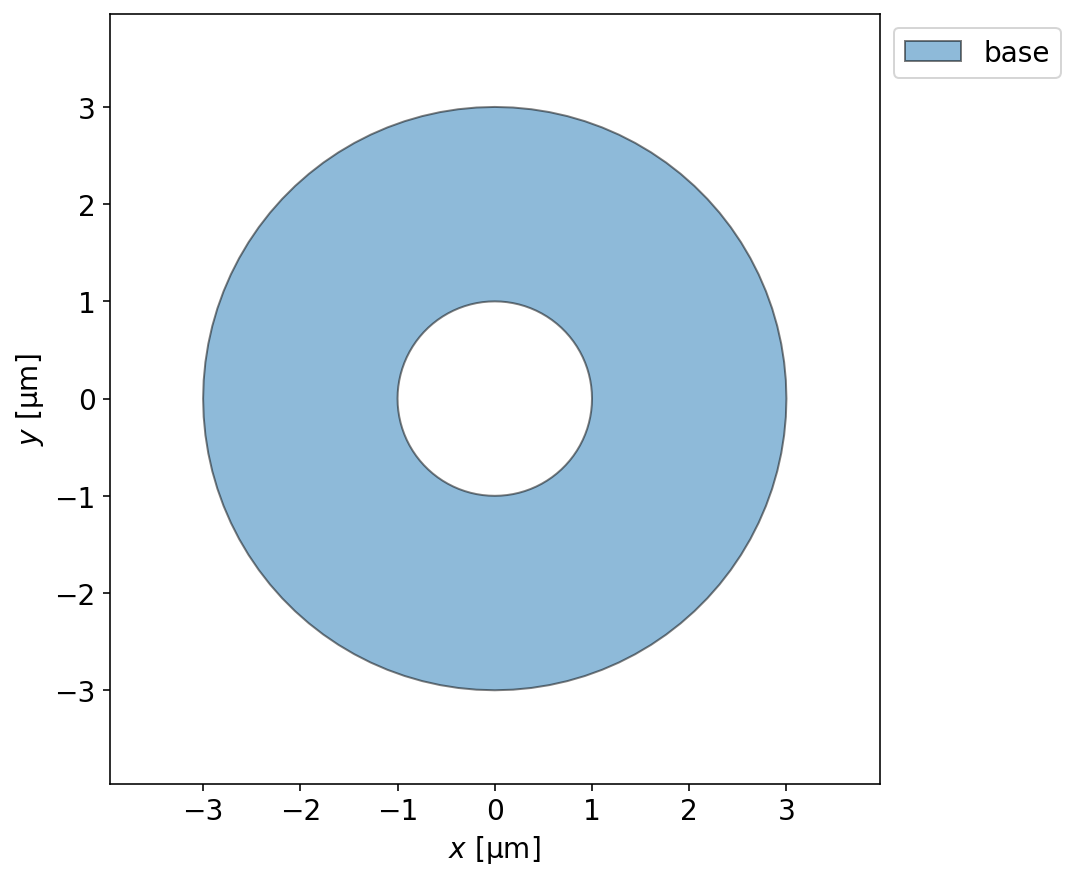

In [3]:
length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)

ring = circle(ro)
hole = circle(ri)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    "ring",
    layers=[sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)],
    films=[sc.Polygon("ring", layer="base", points=ring)],
    holes=[sc.Polygon("hole", layer="base", points=hole)],
    abstract_regions=[bounding_box],
    length_units=length_units,
)
device.solve_dtype = "float32"

fig, ax = device.draw(exclude="bounding_box", legend=True)

In [7]:
# Model the device with 1 mA circulating current
circulating_currents = {"hole": "1 mA"}
solve_kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
    log_level=None,
)

# Look at solve time vs. mesh size
min_points = 1000 * np.arange(1, 11, dtype=int)

In [8]:
mesh_sizes, results = run_benchmark(device, min_points, solve_kwargs)

Mesh size: 1005
    Numpy (CPU): 23.7 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    JAX (CPU): 92.1 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 2043
    Numpy (CPU): 273 ms ± 76.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 142 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 3083
    Numpy (CPU): 274 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 332 ms ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 4178
    Numpy (CPU): 720 ms ± 39.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 750 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 5089
    Nump

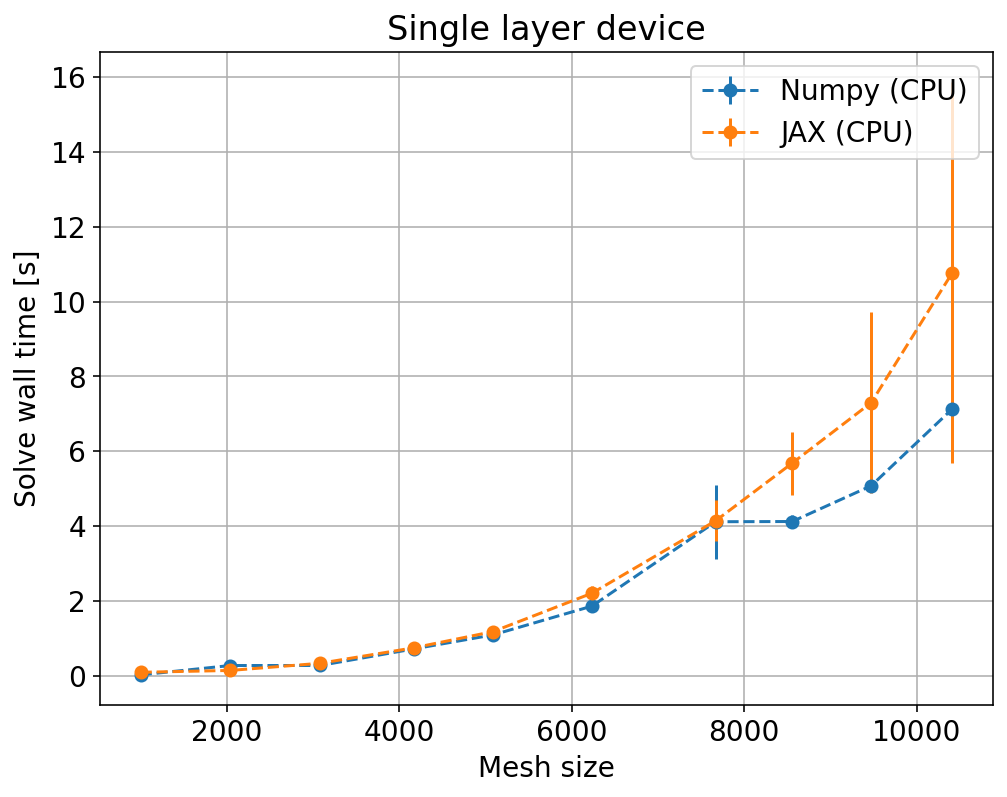

In [9]:
fig, ax = plot_benchmark(mesh_sizes, results)
_ = ax.set_title("Single layer device")

## Multi-layer device

Here we model a scanning Superconducting QUantum Interference Device (SQUID) susceptometer, which consists of three superconducting layers.

In [10]:
import squids

In [19]:
device = squids.ibm.large.make_squid()
device.solve_dtype = "float32"

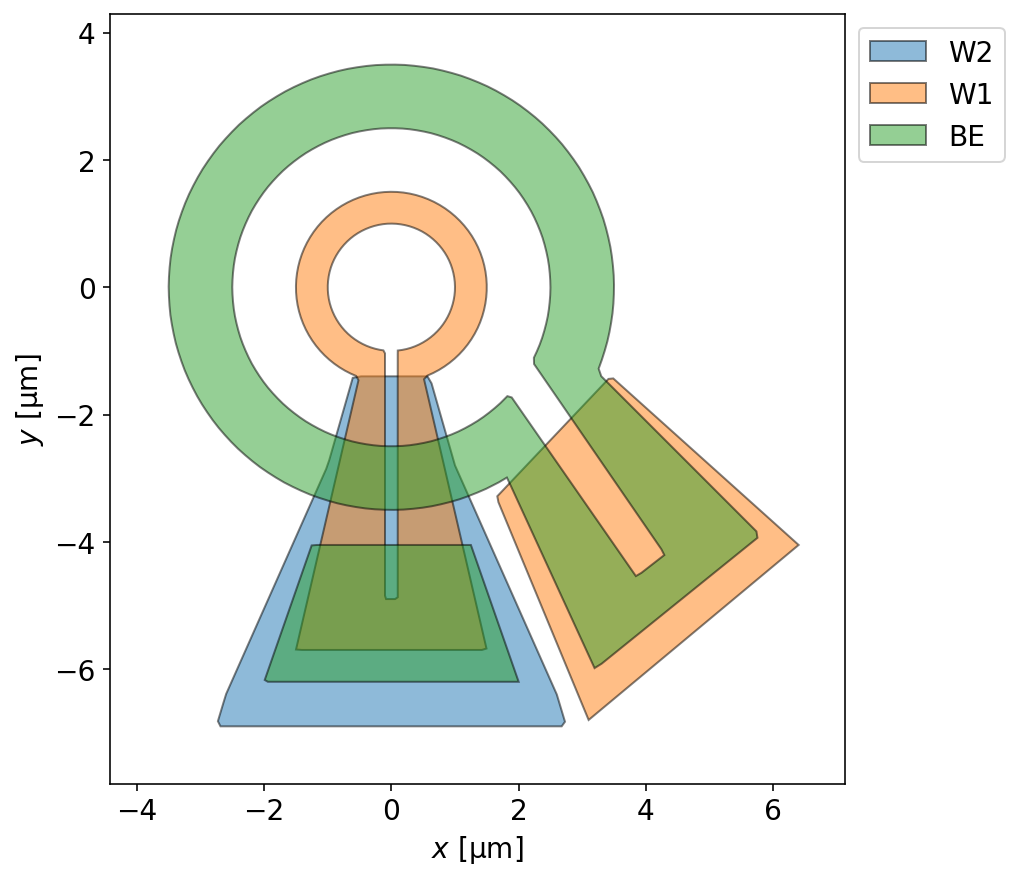

In [20]:
_ = device.draw(exclude="bounding_box", legend=True)

In [21]:
# Model the device with 1 mA circulating current
I_circ = device.ureg("1 mA")
circulating_currents = {"fc_center": str(I_circ)}
solve_kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
    log_level=None,
    iterations=5,
)

import logging
logging.getLogger("superscreen.solve").setLevel(logging.CRITICAL)

# Look at solve time vs. mesh size
min_points = 1000 * np.arange(2, 11, dtype=int)

In [22]:
mesh_sizes, results = run_benchmark(device, min_points, solve_kwargs)

Mesh size: 2237
    Numpy (CPU): 1.35 s ± 93.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 1.83 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 3011
    Numpy (CPU): 2.39 s ± 748 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 2.73 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 4016
    Numpy (CPU): 3.72 s ± 455 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 4.14 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 5464
    Numpy (CPU): 5.85 s ± 379 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 6.69 s ± 224 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): Skipping because there is no GPU available.
Mesh size: 6490
    Numpy (CPU): 10

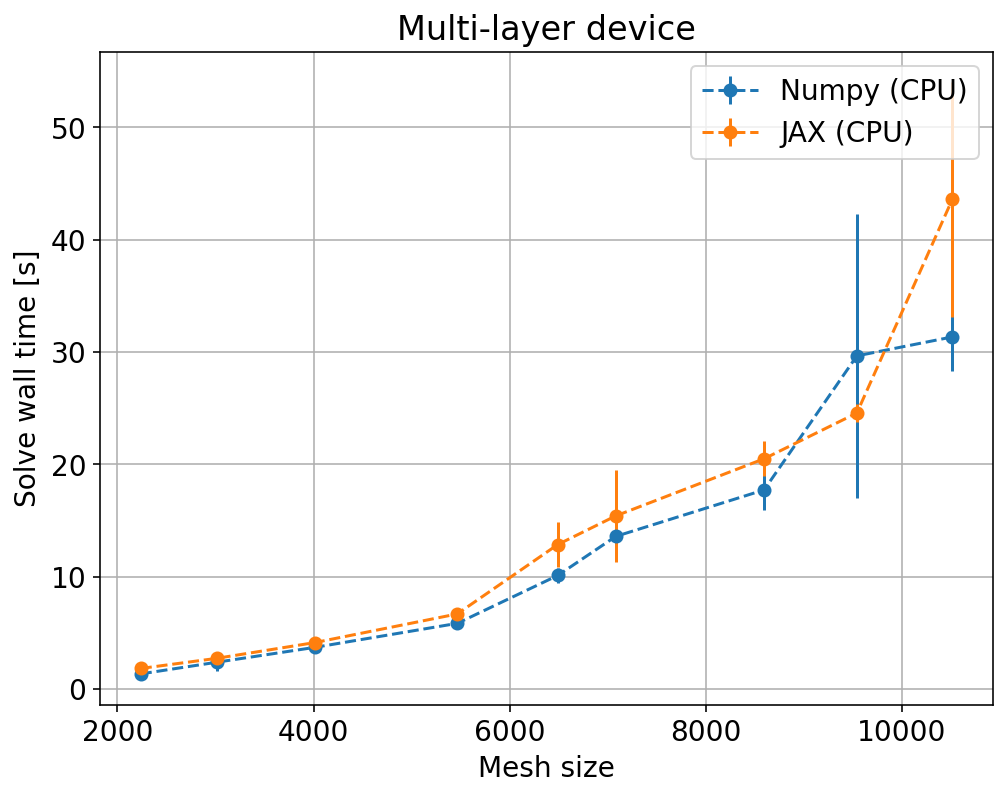

In [23]:
fig, ax = plot_benchmark(mesh_sizes, results)
_ = ax.set_title("Multi-layer device")